## Connectivity and Cell Types - Figure 6

This notebook creates the plots and data presented in Figure 6, Ext. Data Figure 9 and Sup Table 1 of the FlyWire paper. It also shows how cell types were defined based on conectivity.

In [1]:
import os
import dill
import warnings
import pandas as pd
import numpy as np
from scipy import spatial
import itertools
from collections.abc import Iterable

warnings.filterwarnings("ignore")

In [2]:
from flywirepaper import plotting

## Define relevant paths and create directories

In [3]:
data_dir = f"{os.path.realpath('')}/../data"
figure_dir = f"{os.path.realpath('')}/../figures/figure_6/"
figure_source_dir = f"{os.path.realpath('')}/../figures/figure_source_6/"

if not os.path.exists(figure_dir):
    os.makedirs(figure_dir)
    
if not os.path.exists(figure_source_dir):
    os.makedirs(figure_source_dir)

## Loading the connectivity and cell type data

In [4]:
unfiltered_synapse_df = pd.read_hdf(f"{data_dir}/mech_synapses_unfiltered.h5", "data")

In [5]:
mech_cell_types = pd.read_csv(f"{data_dir}/mech_celltypes_unfiltered.csv")

In [6]:
false_pos_celltype_pairs = pd.read_csv(f"{data_dir}/false_pos_celltype_pairs.csv")

In [7]:
with open(f"{data_dir}/cell_type_dict_unfiltered.dl", "rb") as f:
    cell_type_dict = dill.load(f)
    
cell_type_dict_vec = np.vectorize(cell_type_dict.get)

In [8]:
with open(f"{data_dir}/color_dict.dl", "rb") as f:
    cell_type_color_dict = dill.load(f)
    
for k in list(cell_type_color_dict.keys()):
    if "," in str(k):
        cell_type_color_dict[k.split(",")[0]] = cell_type_color_dict[k]

## Synapse filtering

We filter synapses between the two partners if they are within 150 nm. We further filter synapses with low `cleft_scores` to eliminate false positives.

In [9]:
def distance_filter_syn_mask(synapse_df):
    pre_coords = np.array(synapse_df[["pre_x", "pre_y", "pre_z"]])
    connections = np.array(synapse_df[["pre_id", "post_id"]], dtype=np.uint64)
    connections = np.ascontiguousarray(connections)

    connections_v = connections.view(dtype='u8,u8').reshape(-1)
    pre_syn_kdtree = spatial.cKDTree(pre_coords)

    clustered_syn_ids = pre_syn_kdtree.query_ball_point(pre_coords, r=150)

    removed_ids = set()
    valid_ids = []
    for i_cl in range(len(clustered_syn_ids)):
        if connections[i_cl, 0] == connections[i_cl, 1]:
            removed_ids.add(i_cl)
            continue
        
        if i_cl in removed_ids:
            continue

        if len(clustered_syn_ids[i_cl]) > 1:
            local_cluster_ids = np.array(clustered_syn_ids[i_cl])
            conn_m = connections_v[local_cluster_ids] == connections_v[i_cl]
            for id_ in local_cluster_ids[conn_m]:
                if id_ == i_cl:
                    continue

                removed_ids.add(id_)
        valid_ids.append(i_cl)

    valid_ids = np.array(valid_ids)
    removed_ids = np.array(list(removed_ids))
    
    assert len(valid_ids) + len(removed_ids) == len(clustered_syn_ids)

    syn_mask = np.ones(len(synapse_df), dtype=np.bool)
    syn_mask[removed_ids] = False
    
    return syn_mask

In [10]:
synapse_df = unfiltered_synapse_df[unfiltered_synapse_df["cleft score"] >= 50]
synapse_df = synapse_df[synapse_df["pre_id"] != synapse_df["post_id"]]

In [11]:
dist_mask = distance_filter_syn_mask(synapse_df)
synapse_df = synapse_df[dist_mask]

## Build wiring matrix

In [12]:
# Initialize with empty connections
all_possible_connections = np.array(list(itertools.product(cell_type_dict.keys(), cell_type_dict.keys())))

# Update with actual connections
connections = np.array(synapse_df[["pre_id", "post_id"]], dtype=np.uint64)

connection_dict = {"pre_id": np.concatenate([all_possible_connections[:, 0], connections[:, 0]]),
                   "post_id": np.concatenate([all_possible_connections[:, 1], connections[:, 1]]),
                   "nsyn": np.concatenate([np.zeros(len(all_possible_connections), dtype=np.int), np.ones(len(connections), dtype=np.int)])}

df = pd.DataFrame.from_dict(connection_dict)
mech_df = df.groupby(["pre_id", "post_id"]).aggregate({"nsyn": np.sum}).reset_index()

mech_df["pre_type"] = cell_type_dict_vec(mech_df["pre_id"])
mech_df["post_type"] = cell_type_dict_vec(mech_df["post_id"])

We evaluated a sample of synapses between all cell type - cell type connections. For some cell type - cell type connections we found no synapses and removed all automatically detected ones.

In [13]:
coarse_cts = np.array([[ct.split(",")[0] for ct in np.array(mech_df["pre_type"])],
                       [ct.split(",")[0] for ct in np.array(mech_df["post_type"])]]).T

for rm_pair in np.array(false_pos_celltype_pairs):
    mask = np.logical_and(coarse_cts[:, 0] == rm_pair[0], coarse_cts[:, 1] == rm_pair[1])
    mech_df["nsyn"][mask] = 0

## Sub cell typing

In [14]:
def add_subtypes(neuron_ids, sub_type):
    if not isinstance(neuron_ids, Iterable):
        neuron_ids = [neuron_ids]
        
    for neuron_id in neuron_ids:
        assert neuron_id not in sub_cell_type_dict
        sub_cell_type_dict[neuron_id] = sub_type
        
    pre_m = np.isin(mech_sub_df["pre_id"], neuron_ids)
    post_m = np.isin(mech_sub_df["post_id"], neuron_ids)

    mech_sub_df["pre_subtype"][pre_m] = sub_type
    mech_sub_df["post_subtype"][post_m] = sub_type

In [15]:
sub_cell_type_dict = {}
mech_sub_df = mech_df.copy()
mech_sub_df["pre_subtype"] = ""
mech_sub_df["post_subtype"] = ""

### WED-VLP

WED-VLP: Neurons receiving more than 10 synapses from the ipsilateral AMMC-A2 were classified as WED-VLP-1, all others as WED-VLP-2.

In [16]:
wedvlp_post_mask = np.isin(mech_df["post_type"], ["WED-VLP, right", "WED-VLP, left"])
wedvlp_post_df = mech_df[wedvlp_post_mask]

In [17]:
wedvlp_post_dfg = wedvlp_post_df.groupby(["pre_type", "post_id"], as_index=False).aggregate({"nsyn": "sum", "post_type": "min"})

wedvlp_ammca2_left_mask = np.logical_and(wedvlp_post_dfg["pre_type"] == "AMMC-A2, left",
                                         wedvlp_post_dfg["post_type"] == "WED-VLP, left")
  
wedvlp_ammca2_right_mask = np.logical_and(wedvlp_post_dfg["pre_type"] == "AMMC-A2, right",
                                          wedvlp_post_dfg["post_type"] == "WED-VLP, right")

In [18]:
wedvlp_ammc_left_10_mask = wedvlp_post_dfg[wedvlp_ammca2_left_mask]["nsyn"] > 10
wedvlp_ammc_right_10_mask = wedvlp_post_dfg[wedvlp_ammca2_right_mask]["nsyn"] > 10

add_subtypes(np.array(wedvlp_post_dfg[wedvlp_ammca2_left_mask][wedvlp_ammc_left_10_mask]["post_id"]), "WED-VLP-1, left")
add_subtypes(np.array(wedvlp_post_dfg[wedvlp_ammca2_left_mask][~wedvlp_ammc_left_10_mask]["post_id"]), "WED-VLP-2, left")

add_subtypes(np.array(wedvlp_post_dfg[wedvlp_ammca2_right_mask][wedvlp_ammc_right_10_mask]["post_id"]), "WED-VLP-1, right")
add_subtypes(np.array(wedvlp_post_dfg[wedvlp_ammca2_right_mask][~wedvlp_ammc_right_10_mask]["post_id"]), "WED-VLP-2, right")

### AMMC-B1

AMMC-B1: We first selected neurons with more than 30 synapses onto any WED-VLP. These were then labeled as AMMC-B1-1 if they made more than 50% of their WED-VLP synapses onto WED-VLP-1 and AMMC-B1-2 otherwise. Out of the remaining AMMC-B1 neurons (not -1 or -2), those with more than 80 synapses onto any WV-WV neuron were labeled as AMMC-B1-4. From the remaining AMMC-B1 cells, we labeled those as AMMC-B1-3 if they made at least 20 synapses onto AMMC-A1, AMMC-A2 and GFN cells combined. The remaining cells were classified as AMMC-B1-u. 


#### AMMC-B1-1 & - 2

We first selected neurons with more than 30 synapses onto any WED-VLP.

In [19]:
# Selecting connectivity from AMMC-B1 -> WED-VLP
ammcb1_pre_mask = np.isin(mech_sub_df["pre_type"], ["AMMC-B1, right", "AMMC-B1, left"])
wedvlp_post_mask = np.isin(mech_sub_df["post_type"], ["WED-VLP, right", "WED-VLP, left"])

wedvlp_ammcb1_df = mech_sub_df[np.logical_and(ammcb1_pre_mask, wedvlp_post_mask)].copy()

In [20]:
# Grouping by AMMC-B1 and summing synapses. Selecting AMMC-B1s with more than 30 synapses onto all WED-VLPs

ammcb1_dfg = wedvlp_ammcb1_df.groupby(["pre_id"], as_index=False).aggregate({"nsyn": "sum"})
ammcb1_12_ids = np.array(ammcb1_dfg[ammcb1_dfg["nsyn"] >= 30]["pre_id"])
wedvlp_ammcb1_12_df = wedvlp_ammcb1_df[np.isin(wedvlp_ammcb1_df["pre_id"], ammcb1_12_ids)]

These were then labeled as AMMC-B1-1 if they made more than 50% of their WED-VLP synapses onto WED-VLP-1 and AMMC-B1-2 otherwise.

In [21]:
# Rewriting the subtypes to omit hemispheres for wed-vlps
wedvlp_ammcb1_12_df["post_subtype"] = [c.split(",")[0] for c in wedvlp_ammcb1_12_df["post_subtype"]]

# Grouping by AMMC-B1 and counting synapses per wedvlp subtype
wedvlp_ammcb1_12_dfg = wedvlp_ammcb1_12_df.groupby(["pre_id", "post_subtype"]).aggregate({"nsyn": "sum"})

In [22]:
wedvlp_ammcb1_12_dfg.head(10)

nsyn
pre_id             post_subtype      
720575940606332629 WED-VLP-1      137
                   WED-VLP-2        9
720575940607188036 WED-VLP-1      208
                   WED-VLP-2        0
720575940607371076 WED-VLP-1        2
                   WED-VLP-2      155
720575940609843865 WED-VLP-1      165
                   WED-VLP-2        1
720575940611277293 WED-VLP-1      198
                   WED-VLP-2        0

In [23]:
# Extracting subtypes

ammc_b1_12_intsubtypes = []
for ammcb1_id in ammcb1_12_ids:
    sub_df = wedvlp_ammcb1_12_dfg.loc[ammcb1_id].reset_index()

    if sub_df[sub_df["nsyn"] == sub_df["nsyn"].max()]["post_subtype"].values[0].endswith("1"):        
        sub_celltype = cell_type_dict[ammcb1_id].replace(",", "-1,")
    else:
        sub_celltype = cell_type_dict[ammcb1_id].replace(",", "-2,")
        
    add_subtypes(ammcb1_id, sub_celltype)

#### AMMC-B1-4

From the remaining AMMC-B1 cells, we labeled those as AMMC-B1-4 if they made at least 20 synapses onto AMMC-A1, AMMC-A2 and GFN cells combined. 

In [24]:
# Conectivity of the remaining AMMC-B1s
ammcb1r_pre_mask = np.isin(mech_sub_df["pre_subtype"], [""])
ammcb1_pre_mask = np.isin(mech_sub_df["pre_type"], ["AMMC-B1, right", "AMMC-B1, left"])
escape_post_mask = np.isin(mech_sub_df["post_type"], ["GFN, left", "GFN, right","AMMC-A1, right", "AMMC-A1, left","AMMC-A2, right", "AMMC-A2, left"])

mask = ammcb1r_pre_mask * ammcb1_pre_mask * escape_post_mask

In [25]:
ammcb1_escape_dfg = mech_sub_df[mask].groupby("pre_id").aggregate({"nsyn": "sum"})

In [26]:
for ammcb1_id in ammcb1_escape_dfg.index:
    if ammcb1_escape_dfg.loc[ammcb1_id]["nsyn"] > 20:        
        sub_celltype = cell_type_dict[ammcb1_id].replace(",", "-4,")
        add_subtypes(ammcb1_id, sub_celltype)

#### AMMC-B1-3

Out of the remaining AMMC-B1 neurons (not -1, -2 or -4), those with more than 80 synapses onto any WV-WV neuron were labeled as AMMC-B1-3

In [27]:
# Conectivity of the remaining AMMC-B1s onto WV-WV
ammcb1r_pre_mask = np.isin(mech_sub_df["pre_subtype"], [""])
ammcb1_pre_mask = np.isin(mech_sub_df["pre_type"], ["AMMC-B1, right", "AMMC-B1, left"])
wvwv_post_mask = mech_sub_df["post_type"] == "WV-WV"

mask = wvwv_post_mask * ammcb1_pre_mask * ammcb1r_pre_mask

# Aggregate synapses onto wv-wv
ammcb1_wvwv_dfg = mech_sub_df[mask].groupby("pre_id").aggregate({"nsyn": "sum"})

In [28]:
for ammcb1_id in ammcb1_wvwv_dfg.index:
    if ammcb1_wvwv_dfg.loc[ammcb1_id]["nsyn"] > 80:   
        sub_celltype = cell_type_dict[ammcb1_id].replace(",", "-3,")
        add_subtypes(ammcb1_id, sub_celltype)

#### AMMC-B1u

The remaining cells were classified as AMMC-B1-u. 

In [29]:
ammcb1r_pre_mask = np.isin(mech_sub_df["pre_subtype"], [""])
ammcb1_pre_mask = np.isin(mech_sub_df["pre_type"], ["AMMC-B1, right", "AMMC-B1, left"])

mask = ammcb1r_pre_mask * ammcb1_pre_mask
for ammcb1_id in np.unique(mech_sub_df[mask]["pre_id"]):
    sub_celltype = cell_type_dict[ammcb1_id].replace(",", "-u,")
    add_subtypes(ammcb1_id, sub_celltype)

### WV-WV

WV-WV: First, we labeled all WV-WV neurons with more than 20 synapses onto AMMC-A1, AMMC-A2 and GFN combined as WV-WV-3. Out of the remaining neurons, we labeled those with more than 100 synapses onto WED-VLP as WV-WV-1. WV-WV-2 was made up of all remaining WV-WV neurons. 


#### WV-WV-3

WV-WV: First, we labeled all WV-WV neurons with more than 20 synapses onto AMMC-A1, AMMC-A2 and GFN combined as WV-WV-3.

In [30]:
# Conectivity of the WV-WV
wvwv_pre_mask = np.isin(mech_sub_df["pre_type"], ["WV-WV"])
escape_post_mask = np.isin(mech_sub_df["post_type"], ["GFN, left", "GFN, right","AMMC-A1, right", "AMMC-A1, left","AMMC-A2, right", "AMMC-A2, left"])

mask = wvwv_pre_mask * escape_post_mask

# Aggregate synapses
wvwv_esc_dfg = mech_sub_df[mask].groupby("pre_id").aggregate({"nsyn": "sum"})

In [31]:
for wvwv_id in wvwv_esc_dfg.index:
    if wvwv_esc_dfg.loc[wvwv_id]["nsyn"] > 20:   
        sub_celltype = f"{cell_type_dict[wvwv_id]}-3"
        add_subtypes(wvwv_id, sub_celltype)

#### WV-WV-1

Out of the remaining neurons, we labeled those with more than 100 synapses onto WED-VLP as WV-WV-1.

In [32]:
# Conectivity of the WV-WV
wvwvr_pre_mask = np.isin(mech_sub_df["pre_subtype"], [""])
wvwv_pre_mask = np.isin(mech_sub_df["pre_type"], ["WV-WV"])
wedvlp_post_mask = np.isin(mech_sub_df["post_type"], ["WED-VLP, left", "WED-VLP, right"])

mask = wvwvr_pre_mask * wvwv_pre_mask * wedvlp_post_mask

# Aggregate synapses
wvwv_wedvlp_dfg = mech_sub_df[mask].groupby("pre_id").aggregate({"nsyn": "sum"})

In [33]:
for wvwv_id in wvwv_wedvlp_dfg.index:
    if wvwv_wedvlp_dfg.loc[wvwv_id]["nsyn"] > 100:   
        sub_celltype = f"{cell_type_dict[wvwv_id]}-1"
        add_subtypes(wvwv_id, sub_celltype)

#### WV-WV-2

WV-WV-2 was made up of all remaining WV-WV neurons. 

In [34]:
wvwvr_pre_mask = np.isin(mech_sub_df["pre_subtype"], [""])
wvwv_pre_mask = np.isin(mech_sub_df["pre_type"], ["WV-WV"])

mask = wvwvr_pre_mask * wvwv_pre_mask
for wvwv_id in np.unique(mech_sub_df[mask]["pre_id"]):
    sub_celltype =  f"{cell_type_dict[wvwv_id]}-2"
    add_subtypes(wvwv_id, sub_celltype)

## Plots

In [35]:
from matplotlib import pyplot as plt

## Wed-VLP plot

In [36]:
post_m = np.isin(mech_sub_df["post_type"], ["WED-VLP, left", "WED-VLP, right"])
pre_m = np.isin(mech_sub_df["pre_type"], ["AMMC-A2, left", "AMMC-A2, right"])
comb_m = np.logical_and(pre_m, post_m)

ammca2_wedvlp_df = mech_sub_df[comb_m].copy()
ammca2_wedvlp_df["pre_hemisphere"] = [t.split(", ")[1] for t in np.array(ammca2_wedvlp_df["pre_type"])]
ammca2_wedvlp_df["post_hemisphere"] = [t.split(", ")[1] for t in np.array(ammca2_wedvlp_df["post_type"])]
ammca2_wedvlp_df["post_subtype_blank"] = [t.split(", ")[0] for t in np.array(ammca2_wedvlp_df["post_subtype"])]

ammca2_wedvlp_df = ammca2_wedvlp_df[ammca2_wedvlp_df["pre_hemisphere"] == ammca2_wedvlp_df["post_hemisphere"]]

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


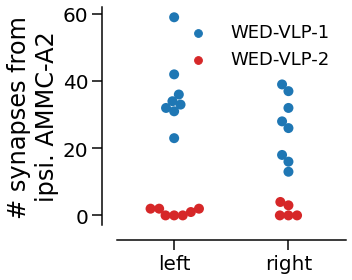

In [37]:
plotting.swarmplot(ammca2_wedvlp_df, 
                   x_key="pre_hemisphere",
                   y_key="nsyn", 
                   hue_key="post_subtype_blank", 
                   figsize=(5, 4),
                   ylabel="# synapses from\nipsi. AMMC-A2",
                   color_list=[cell_type_color_dict["WED-VLP-1"], cell_type_color_dict["WED-VLP-2"]],
                   path=f"{figure_dir}/summarized_ammca2_connectivity_wedvlp.png")

### Matrix plot

In [38]:
# Predefined order

cell_type_order = [
    "GFN",
    "AMMC-A1",
    "AMMC-A2",
    "AMMC-B1",
    "AMMC-B2",
    "WED-VLP",
    "WV-WV"
]

In [39]:
combined_cell_type_dict = cell_type_dict.copy()
combined_cell_type_dict.update(sub_cell_type_dict)
combined_cell_type_dict_vec = np.vectorize(combined_cell_type_dict.get)

In [40]:
# Sorting by major cell type, then hemisphere, then subtype

combined_cell_type_dict = cell_type_dict.copy()
combined_cell_type_dict.update(sub_cell_type_dict)
combined_cell_type_dict_vec = np.vectorize(combined_cell_type_dict.get)

neuron_ids = np.array(list(combined_cell_type_dict.keys()))
neuron_cell_types = np.array(list(combined_cell_type_dict.values()))

ordered_neuron_ids = []
for cell_type in cell_type_order:
    sel_neuron_ids = neuron_ids[[ct.startswith(cell_type) for ct in neuron_cell_types]]
    sel_sub_celltypes = combined_cell_type_dict_vec(sel_neuron_ids)
    sub_sorting = np.argsort(["".join(ct.split(", ")[::-1]) for ct in sel_sub_celltypes])
    
    ordered_neuron_ids.extend(sel_neuron_ids[sub_sorting])

In [41]:
# Generate ordered matrix 

mech_df_2d = mech_df.pivot_table(index="pre_id", columns="post_id", 
                                 values="nsyn", fill_value=0, dropna=False)
mech_df_2d = mech_df_2d.loc[ordered_neuron_ids].T.loc[ordered_neuron_ids].T

### Sorting by cell type

In [42]:
def plot_matrix(data, cell_types_x=None, cell_types_y=None,
                combined_cell_types_x=None, combined_cell_types_y=None,
                is_symmetric=True, color_dict={},
                figsize=(16, 14), cb_label="# synapses", show_legend=True,
                cmap="Greys", min_n_syn=0, max_syn=20, path=None):
    
    def get_name_bounds(names):
        starts = [0]
        u_names = [names[0]]
        temp_name = names[0]
        for i_name in range(1, len(names)):
            if temp_name == names[i_name]:
                continue
            else:
                starts.append(i_name)
                u_names.append(names[i_name])
                temp_name = names[i_name]

        starts.append(len(names))

        starts = np.array(starts)

        return u_names, starts
    
    fig = plt.figure(figsize=figsize, facecolor="white")
    plt.tick_params(length=0, width=0, labelsize=0)
    ax = plt.gca()

    plt.axes().spines['bottom'].set_linewidth(0)
    plt.axes().spines['left'].set_linewidth(0)
    plt.axes().spines['right'].set_linewidth(0)
    plt.axes().spines['top'].set_linewidth(0)

    # Core plot
    cmap_d = plt.cm.get_cmap(cmap, max_syn + 1 - min_n_syn) 
    im = plt.imshow(data, cmap=cmap_d, vmax=max_syn+.5, aspect="auto", vmin=min_n_syn-.5)

    # Divider lines
    if cell_types_x is not None:
        coarse_lines_x = get_name_bounds([ct.split(',')[0] for ct in cell_types_x])
        fine_lines_x = get_name_bounds(cell_types_x)

        if is_symmetric:
            coarse_lines_y = coarse_lines_x
            fine_lines_y = fine_lines_x
        else:
            coarse_lines_y = get_name_bounds([ct.split(',')[0] for ct in cell_types_y])
            fine_lines_y = get_name_bounds(cell_types_y)

        plt.hlines(y=fine_lines_y[1][1:-1]-.5, xmin=-3, xmax=data.shape[1] - .5, color='.5', lw=1)
        plt.vlines(x=fine_lines_x[1][1:-1]-.5, ymin=-0.5, ymax=data.shape[0] + 2, color='.5', lw=1)

        plt.hlines(y=coarse_lines_y[1][1:-1]-.5, xmin=-3, xmax=data.shape[1] - .5, color='k', lw=2)
        plt.vlines(x=coarse_lines_x[1][1:-1]-.5, ymin=-0.5, ymax=data.shape[0] + 2, color='k', lw=2)

    # Cell type color blocks
    if combined_cell_types_x is not None:
        ct_blocks_x = get_name_bounds([ct.split(',')[0] for ct in combined_cell_types_x])
        
        if is_symmetric:
            ct_blocks_y = ct_blocks_x
        else:
            ct_blocks_y = get_name_bounds([ct.split(',')[0] for ct in combined_cell_types_y])
        
        for i_start in range(len(ct_blocks_x[0])):
            name_sub = ct_blocks_x[0][i_start]
            start_sub = ct_blocks_x[1][i_start]
            end_sub = ct_blocks_x[1][i_start + 1]

            rect = mpl_patches.Rectangle((start_sub-.5, data.shape[0]), 
                                         end_sub - start_sub, 2, 
                                         linewidth=0, 
                                         facecolor=color_dict[name_sub], 
                                         edgecolor=None)
            ax.add_patch(rect)

        for i_start in range(len(ct_blocks_y[0])):
            name_sub = ct_blocks_y[0][i_start]
            start_sub = ct_blocks_y[1][i_start]
            end_sub = ct_blocks_y[1][i_start + 1]

            rect = mpl_patches.Rectangle((-3, start_sub-.5), 2, 
                                         end_sub - start_sub, 
                                         linewidth=0, 
                                         facecolor=color_dict[name_sub],
                                         edgecolor=None)
            ax.add_patch(rect)

    fig.tight_layout()

    # Colorbar
    if show_legend:
        cbar = plt.colorbar(im, shrink=.35, orientation="vertical")
        cbar.outline.set_visible(False)
        cbar.ax.tick_params(labelsize=22, length=0) 
        cbar.ax.set_ylabel(cb_label, fontsize=24)

        yticks = np.array(cbar.ax.get_yticks(), dtype=np.int).astype(np.str)

        if int(yticks[-1]) < np.max(np.array(data)):
            yticks[-1] = f"{yticks[-1]}-{np.max(np.array(data))}"
        if 0 < int(yticks[0]):
            yticks[0] = f"0-{yticks[0]}"
        cbar.ax.set_yticklabels(yticks, fontsize=22)
    
    if path is not None:
        plt.savefig(path, dpi=300)
        plt.savefig(f"{path[:-4]}.pdf")
    plt.show()

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


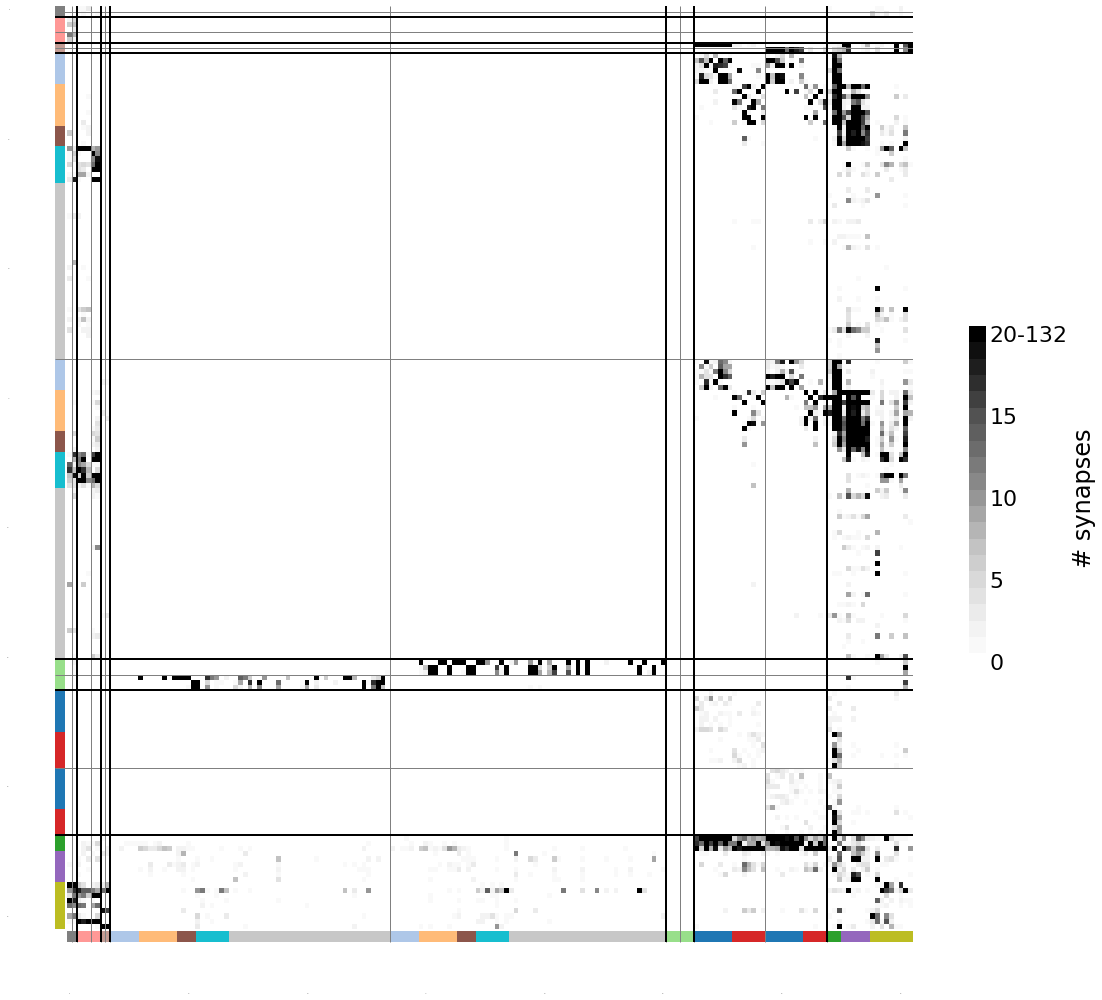

In [43]:
plotting.plot_matrix(mech_df_2d, 
                     cell_types_x=cell_type_dict_vec(ordered_neuron_ids),
                     combined_cell_types_x=combined_cell_type_dict_vec(ordered_neuron_ids),
                     is_symmetric=True, color_dict=cell_type_color_dict, 
                     min_n_syn=0, max_syn=20,
                     path=f"{figure_dir}/connectivity_matrix.png")

In [44]:
mech_sub_df.to_csv(f"{figure_source_dir}/connectivity.csv")